In [5]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.plot_auxiliary import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, get_base_network_name, 
    powerlaw, load_delta_data, read_data_file, powerlaw
)

%matplotlib inline

net_type = 'DT'
param = 'param'

marker_dict = {'meanS': 'o', 'Nsec': 's', 'varSgcc': '^'}
color_dict = {'meanS': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2'}
linestyle_dict = {'meanS': '--', 'Nsec': '-.', 'varSgcc': ':'}
measures_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$', 'varSgcc': r'$\chi$'}
line_colors = {'meanS': 'k', 'Nsec': 'grey', 'varSgcc': 'brown'}

In [27]:
min_nseeds = 1000
measures = ['meanS', 'Nsec']
attacks = [
    'Ran', 'Deg', 'Btw_cutoff2'
]

sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    #print(attack)
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            df = load_dataframe(net_type, N, param, attack, min_nseeds=min_nseeds)
            dfs[N] = df
        except FileNotFoundError:
            continue

    for i, measure in enumerate(measures):
        N_values = np.array(list(dfs.keys()))
        L_values = np.sqrt(N_values)
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        
        Y, _ = getPeaks(dfs, measure)
        #print(measure, N_values)
        #print({N: y for N, y in zip(N_values, Y)})
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_nu = slope
            delta_gamma = y_err       
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    if True:
        print(
            '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
                attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
                2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
            )
        )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Ran       	   0.1193   0.1591   1.6979   2.2639   1.9366   0.1489   2.0657    0.4402    262144
Deg       	   0.1429   0.1906   1.6200   2.1599   1.9058   0.1314   2.0811    0.2300    262144
Btw_cutoff2	   0.1718   0.2290   1.5947   2.1263   1.9383   0.0702   2.0972    0.1341     65536


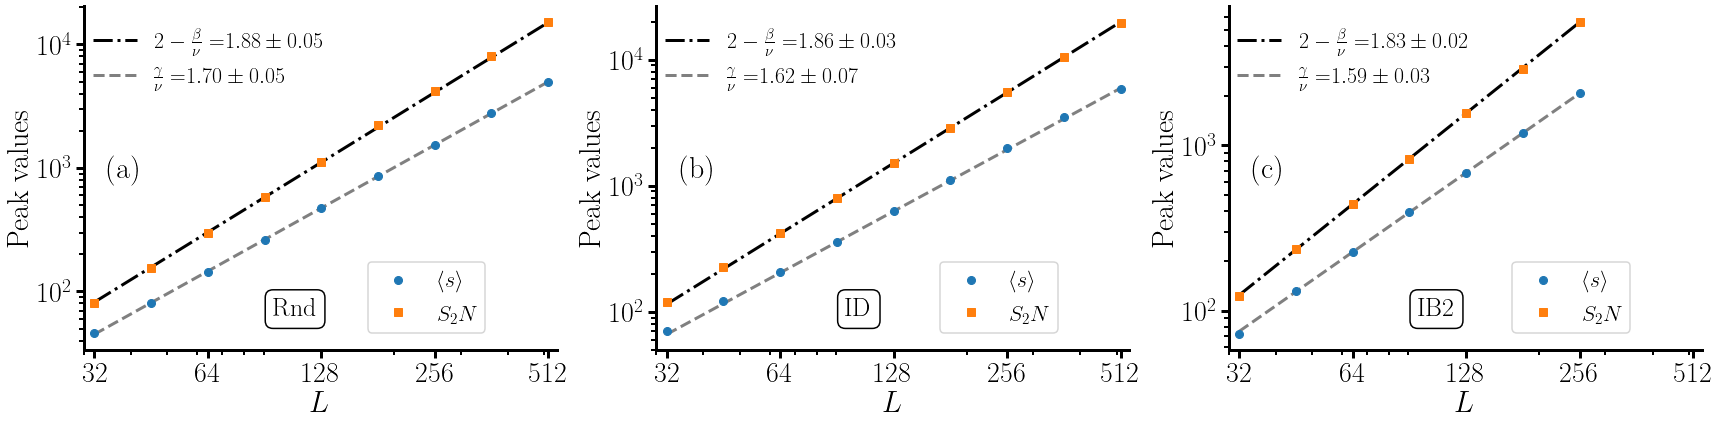

In [28]:
measures = ['meanS', 'Nsec']

ncols = 3
nrows = len(attacks) // ncols + bool(len(attacks) % ncols)
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(30, 540)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
for k, attack in enumerate(attacks):
    ax = axes[k]

    ax.text(0.05, 0.5, letters[k], transform=ax.transAxes, fontsize=30)
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    ax.text(0.4, 0.1, attack_dict[attack], transform=ax.transAxes, fontsize=26, bbox=bbox)
    ax.set_ylabel(r'$\mathrm{Peak\;values}$')

    for i, measure in enumerate(measures):

        L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    
        c = measure_values[3] / L_values[3]**slope
        if measure == 'meanS':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), linestyle_dict[measure], color='grey', label=label)

        elif measure == 'Nsec':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
            label2 = label
            line2, = ax.plot(L_values, powerlaw(L_values, slope, c), linestyle_dict[measure], color='k', label=label)            

        markers1, = ax.plot(
            L_values, measure_values, marker_dict[measure], 
            color=color_dict[measure], markersize=8, 
            label=measures_dict[measure]
        )
        c = color_dict[measure]      

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [1, 3]
    legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.6, 0.05))

    ax.add_artist(legend1)
    ## Lines
    order = [2, 0]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.0, 0.73), frameon=False)

sns.despine()
plt.tight_layout()
plt.show()

In [37]:
attack = 'Ran'

all_sizes = [
    #256, 512, 
    1024, 2048, 4096, 
    8192, 16384, 32768, 65536, 131072, 262144
]
sizes = []
all_mean_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
for i, N in enumerate(all_sizes):
    try:
        delta_data, nseeds = load_delta(net_type, N, param, attack, min_nseeds=1000, return_nseeds=True)
    except FileNotFoundError:
        print(N)
        continue
    print(N, delta_data.shape)
    sizes.append(N)
    nseeds_values.append(nseeds)
    
    delta_data[:,2] = delta_data[:,2]*N
    mean_values = delta_data.mean(axis=0)
    std_values = delta_data.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_data - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]
sizes = np.array(sizes)
print(sizes, rc_values, delta_values)

1024 (10000, 3)
2048 (10000, 3)
4096 (10000, 3)
8192 (10000, 3)
16384 (9991, 3)
32768 (10000, 3)
65536 (10000, 3)
131072 (1000, 3)
262144 (1000, 3)
[  1024   2048   4096   8192  16384  32768  65536 131072 262144] [0.50284951 0.50205469 0.50169631 0.50123187 0.50083725 0.50073774
 0.50051186 0.50065692 0.50039029] [0.12723223 0.1218376  0.11736221 0.11335797 0.10890933 0.10465061
 0.10104853 0.09859936 0.09307237]


In [38]:
rc_per_attack = {
    'Ran': 0.5,
    'Deg': 0.30342,
    'Btw_cutoff2': 0.30060
}

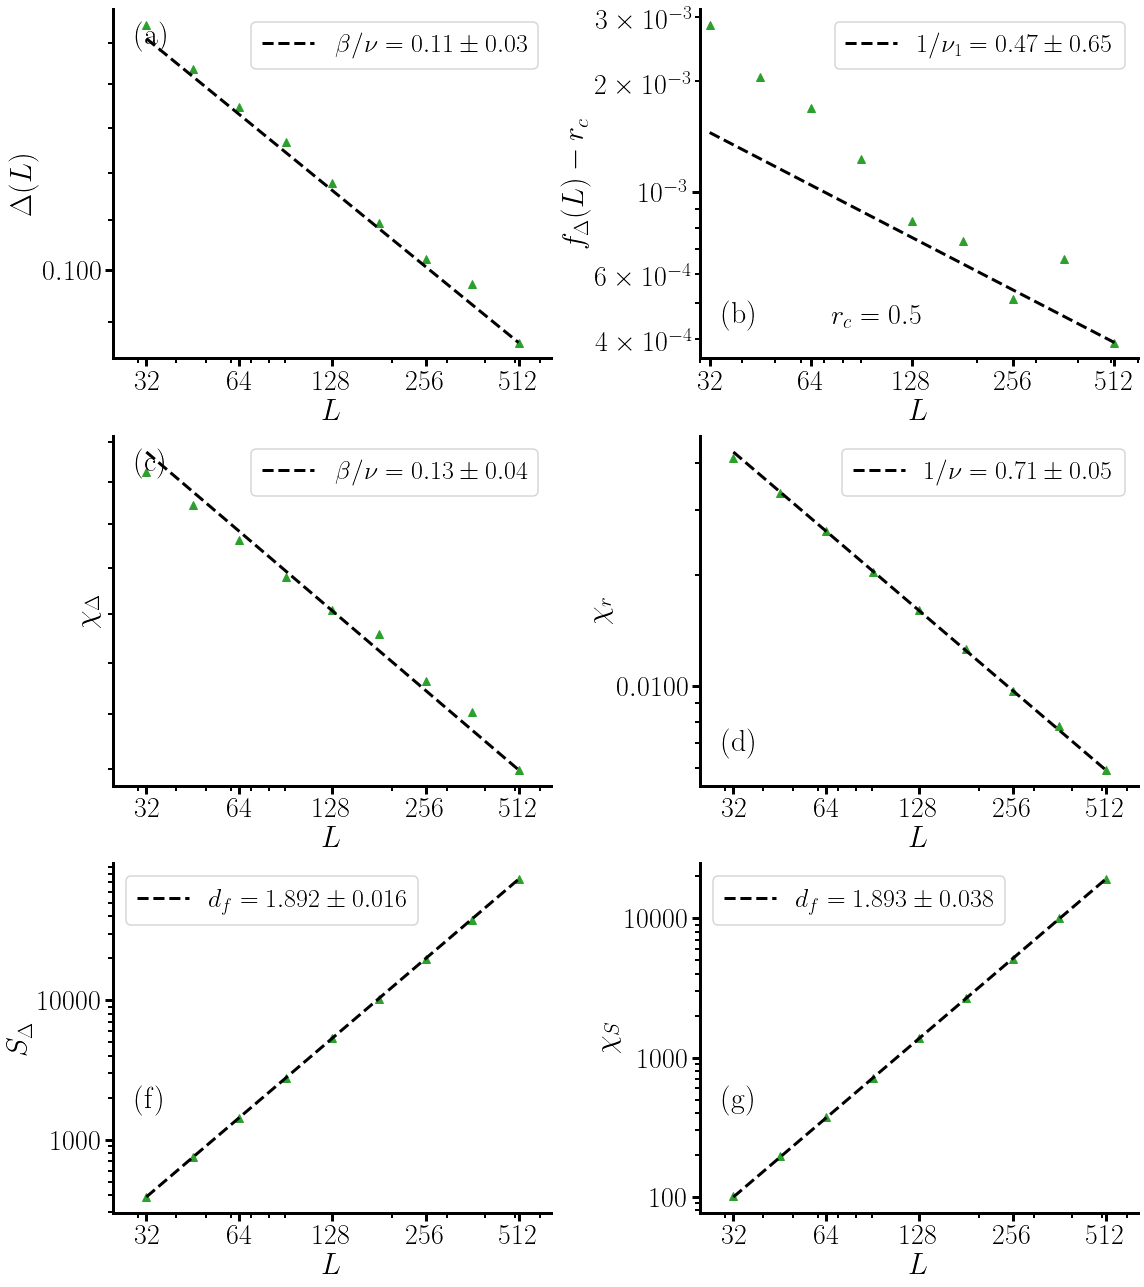

In [39]:
ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(25, 650)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0,0]
ax.text(0.05, 0.9, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta (L)$')
X = np.sqrt(sizes)
Y = all_mean_values[:,1]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.errorbar(X, Y, Y_err, marker='^', color='C2', markersize=8)
label = r'$\beta/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend()

###################################################################

ax = axes[0,1]
ax.text(0.05, 0.1, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_yticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
#ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
#ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$f_{\Delta}(L) - r_c$')
rc = rc_per_attack[attack]
X = np.sqrt(sizes)
Y = np.fabs(rc-all_mean_values[:,0] )
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = r'$1/\nu_1={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
ax.set_xlim(30, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.3, 0.1, r'$r_c={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)
ax.legend()

#############################################################


ax = axes[1,0]
ax.text(0.05, 0.9, letters[2], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.04, 0.072])
#ax.set_yticks([0.04, 0.05, 0.06, 0.07])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
beta_over_nu = -slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = r'$\beta/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend()

###############################################################

ax = axes[1,1]
ax.text(0.05, 0.1, letters[3], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.002, 0.04])
#ax.set_yticks([0.003, 0.01, 0.03])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{r}$')
Y = all_std_values[:,0]

Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$1/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend()

######################################################################

ax = axes[2,0]
ax.text(0.05, 0.3, letters[5], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$S_{\Delta}$')
Y = all_mean_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f={{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend()

###############################################################

ax = axes[2,1]
ax.text(0.05, 0.3, letters[6], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{S}$')
Y = all_std_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f = {{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend()

################################################################

sns.despine()
plt.tight_layout()

plt.show()

In [17]:
d = 2
d_f = 1.87
print('gamma/nu = ',(2*d_f - d))
print('beta/nu = ', (d- d_f))

gamma/nu =  1.7400000000000002
beta/nu =  0.1299999999999999


In [40]:
rc - rc_values

array([1.13727539e-02, 8.60258789e-03, 6.17407227e-03, 4.50820312e-03,
       2.70979614e-03, 1.51610718e-03, 8.31048584e-04, 8.87801620e-05])

# $\dfrac{\langle s \rangle}{L^d S_1^2}$

# $\dfrac{S_2}{S_1}$

# $\dfrac{\gamma }{ d\nu} - \dfrac{d 2\beta}{d\nu}$

In [17]:
def compute_fc_v2(
    dfs, min_f, max_f, method='beta', only_next=False, verbose=False, log=False
):

    N_values = sorted(list(dfs.keys()))


    N1_over_N2 = {}
    for N in N_values:
        if method == 'beta':
            N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            N1_over_N2[N] = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values
        
        if log:
            N1_over_N2[N] = np.log(N1_over_N2[N])

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            if only_next and j != i+1:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            if verbose:
                print(Na, Nb, inter+min_f, sep='\t')
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter


def compute_fc_v3(
    dfs, min_f, max_f, method='beta'
):

    N_values = sorted(list(dfs.keys()))
    metrics = {}
    for N in N_values:
        if method == 'beta':
            metric = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values
        elif method == 'binder':
            metric = dfs[N]['meanS']/(N*(dfs[N]['Sgcc']**2)).values
        metrics[N] = metric + 1/metric

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for i, Na in enumerate(N_values):
        for j, Nb in enumerate(N_values):
            if Nb <= Na:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = metrics[Na][mask]
            Na_values = np.interp(x, xp, fp)
            
            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = metrics[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            
            s += (Na_values-Nb_values)**2
            inter = np.argmin(s)/max_N
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

[(8192, 10000), (16384, 10000), (32768, 10000), (65536, 1000), (131072, 1000), (262144, 1000)]
Ran                 0.50160 +- 0.00098  0.001955
[(8192, 10000), (16384, 10000), (32768, 1000), (65536, 10000), (131072, 1000), (262144, 1000)]
Deg                 0.30355 +- 0.00025  0.000812
[(8192, 1000), (16384, 1000)]
DegU                0.37832 +- 0.00000  0.000000


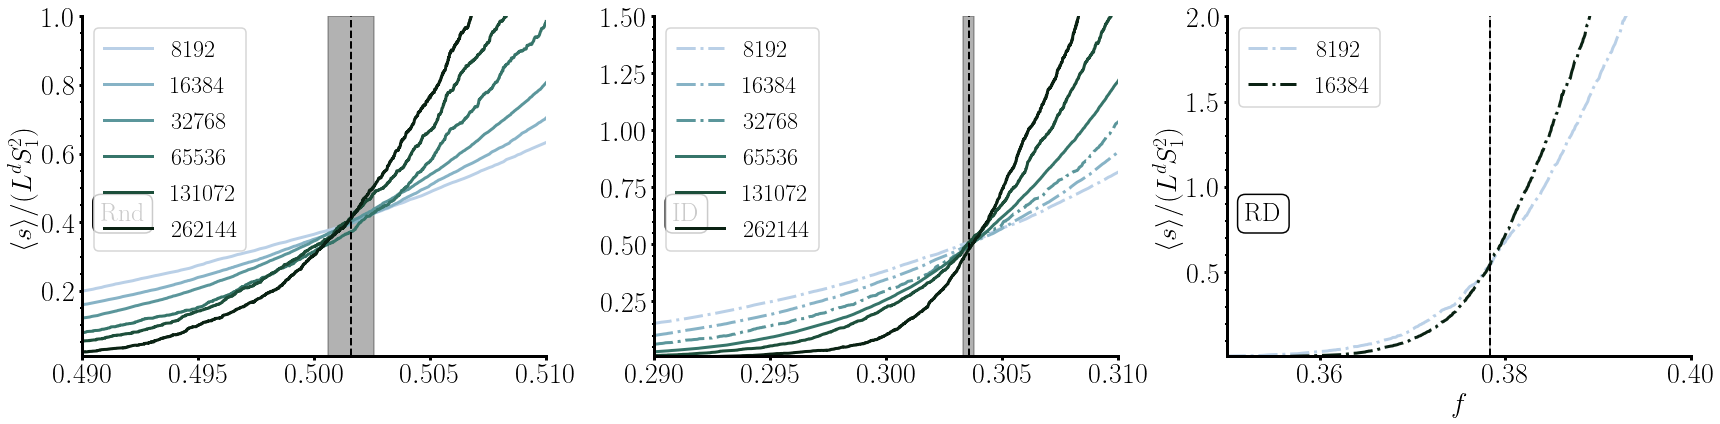

In [22]:
def plot_S1_over_S2(net_type):

    min_nseeds = 1000
    l_values = range(2, 5)
    attacks = ['Ran', 'Deg', 'DegU']# + ['Btw_cutoff%d' % l for l in l_values] #+ ['DegU', 'BtwU', 'CIU']
    
    ncols = 3
    nrows = len(attacks) // ncols 
    if len(attacks) % ncols:
        nrows += 1
    fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    fc_values = {}
    for j, attack in enumerate(attacks):

        sizes = [
            #1024, 2048, 4096, 
            8192, 
            16384, 32768, 65536, 131072, 262144
        ]  
        
        dfs = {}
        for N in sizes:

            try:
                df_cpp = load_dataframe(net_type, N, param, attack, min_nseeds=min_nseeds, method='cpp')
            except FileNotFoundError:
                df_cpp = pd.DataFrame()
                df_cpp.attrs['nseeds'] = 0
            try:
                df_fast = load_dataframe(net_type, N, param, attack, min_nseeds=min_nseeds, method='fast')
            except FileNotFoundError:
                df_fast = pd.DataFrame()
                df_fast.attrs['nseeds'] = 0
                    
            if df_cpp.attrs['nseeds'] > df_fast.attrs['nseeds']:
                df = df_cpp
                df.attrs['algo'] = 'cpp'
            else:
                df = df_fast
                df.attrs['algo'] = 'fast'
            
            if df.attrs['nseeds'] > 0:
                dfs[N] = df
        
        N_values = np.sort(list(dfs.keys()))[-6:]
        L_values = np.sqrt(N_values)
        
        dfs = {N: dfs[N] for N in N_values}
        print([(N, df.attrs['nseeds']) for N, df in dfs.items()])
        
        ax = axes[j]
        if attack == 'Ran':
            fmin = 0.49
            fmax = 0.51
            ymin = 0.001
            ymax = 1.       

        if attack == 'Deg':
            fmin = 0.29
            fmax = 0.31
            ymin = 0.01
            ymax = 1.5
            
        if attack == 'DegU':
            fmin = 0.35
            fmax = 0.4
            ymin = 0.01
            ymax = 2
            
        if attack == 'Btw':
            fmin = 0.
            fmax = 0.1
            ymin = 1.
            ymax = 4.0
            
        if attack == 'Btw_cutoff2':
            fmin = 0.28
            fmax = 0.34
            ymin = 1.
            ymax = 8.0
            
        if attack == 'Btw_cutoff3':
            fmin = 0.25
            fmax = 0.34
            ymin = 1.
            ymax = 8.0
            
        if attack == 'Btw_cutoff4':
            fmin = 0.24
            fmax = 0.3
            ymin = 1.
            ymax = 8.0
            
        if attack == 'Btw_cutoff5':
            fmin = 0.23
            fmax = 0.28
            ymin = 1.
            ymax = 8.0

        if attack == 'Btw_cutoff6':
            fmin = 0.22
            fmax = 0.26
            ymin = 1.
            ymax = 8.0
            
        if attack == 'Btw_cutoff7':
            fmin = 0.22
            fmax = 0.26
            ymin = 1.
            ymax = 8.0
            
        if attack == 'Btw_cutoff8':
            fmin = 0.21
            fmax = 0.25
            ymin = 1.
            ymax = 8
            
        if attack == 'Btw_cutoff9':
            fmin = 0.20
            fmax = 0.24
            ymin = 1.
            ymax = 8
            
        if attack == 'Btw_cutoff10':
            fmin = 0.18
            fmax = 0.24
            ymin = 1.
            ymax = 8
            
        if attack == 'Btw_cutoff11':
            fmin = 0.17
            fmax = 0.25
            ymin = 1.
            ymax = 8
        
        large_l_attacks = [
            'Btw_cutoff12', 'Btw_cutoff13', 
            'Btw_cutoff14', 'Btw_cutoff15', 'Btw_cutoff16'
        ]
        if attack in large_l_attacks:
            fmin = 0.18
            fmax = 0.23
            ymin = 1.
            ymax = 8

            
        ax.set_xlim(fmin, fmax)
        
        log_attacks = [
            'Btw', #'Btw_cutoff6', 
            #'Btw_cutoff8', 
            #'Btw_cutoff12'
        ]
        
        if attack in log_attacks:
            ax.set_yscale('log')
        else:
            ymin= 0.01
            ax.set_ylim(ymin, ymax)
            #ax.set_ylim(0, 10)
            #ax.set_yscale('log')
            #ax.set_xscale('log')
            
        if j in [0, 2]:
            ax.set_ylabel(r'$\langle s \rangle /(L^d S_1^2)$', fontsize=28)
        if j in [2, 3]:
            ax.set_xlabel(r'$f$', fontsize=28)

        colors = sns.cubehelix_palette(len(N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        for i, N in enumerate(N_values):

            df = dfs[N]
            Y = df.meanS / (N*df.Sgcc**2)
            #Y = Y + 1/Y
            if df.attrs['algo'] == 'fast':
                linestyle = '-'
            else:
                linestyle = '-.'
            ax.plot(df.f, Y, linestyle, label=r'${{{}}}$'.format(N), color=colors[i])
        
        if not dfs: ## Dict is empty
            continue

        _dfs = {}
        for k, size in enumerate(sorted(dfs.keys(), reverse=True)):
            if k == 4:
                break
            _dfs[size] = dfs[size]
        mean_fc, std_fc = compute_fc_v2(_dfs, fmin, fmax, only_next=False, verbose=False, log=False, method='binder')
        #mean_fc, std_fc = compute_fc_v3(_dfs, fmin, fmax, method='binder')
        
        fc_values[attack] = (mean_fc, std_fc)
        
        print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.04, 0.4, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        #ax.text(0.04, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
        #        horizontalalignment='left')
        ax.legend(loc='best', fontsize=24)

    sns.despine()
    plt.tight_layout()    
    plt.show()
    
    return fc_values
    
net_type = 'DT'
fc_values = plot_S1_over_S2(net_type=net_type)

In [40]:
attack = 'Ran'
sizes = [
    #1024, 2048, 4096, 
    8192, 
    16384, 32768, 65536, 131072, 262144
]  

dfs_cpp = {}
dfs_fast = {}
nseeds = 10000
for N in sizes:

    try:
        df_cpp = load_dataframe(net_type, N, param, attack, nseeds=nseeds, method='cpp')
    except FileNotFoundError:
        df_cpp = pd.DataFrame()
        df_cpp.attrs['nseeds'] = 0
    try:
        df_fast = load_dataframe(net_type, N, param, attack, nseeds=nseeds, method='fast')
    except FileNotFoundError:
        df_fast = pd.DataFrame()
        df_fast.attrs['nseeds'] = 0

    if df_cpp.attrs['nseeds'] > 0:
        dfs_cpp[N] = df_cpp
    if df_fast.attrs['nseeds'] > 0:
        dfs_fast[N] = df_fast

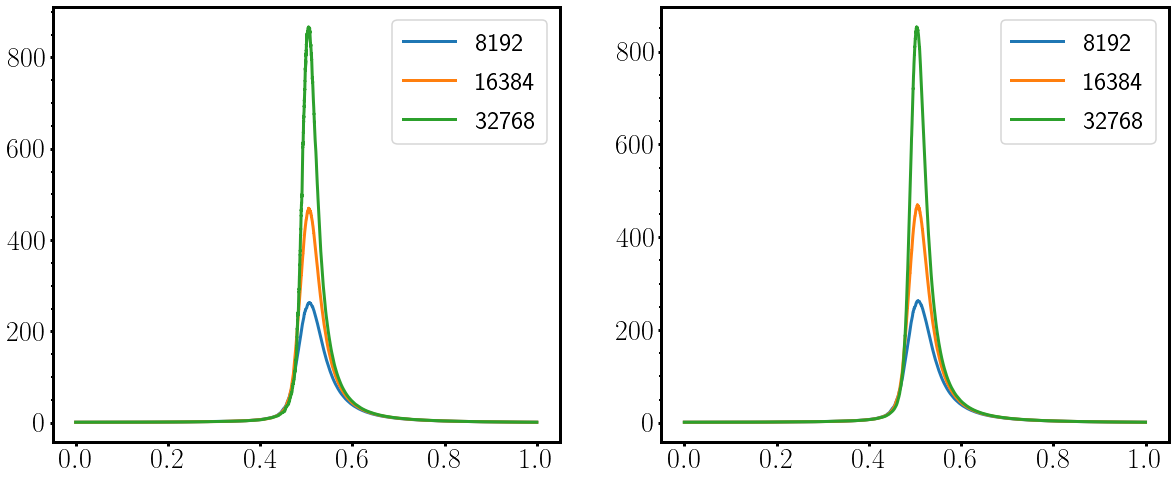

In [41]:
fig, axes = plt.subplots(figsize=(20,8), ncols=2)
ax = axes[0]
for N, df in dfs_cpp.items():
    ax.plot(df.f, df.meanS, label=N)
ax.legend()

ax = axes[1]
for N, df in dfs_fast.items():
    if N not in dfs_cpp:
        continue
    ax.plot(df.f, df.meanS, label=N)
ax.legend()


plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


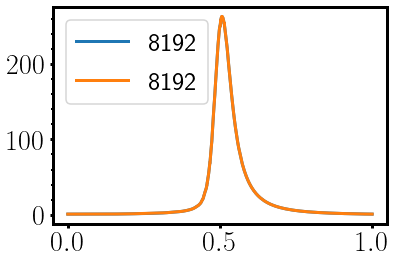

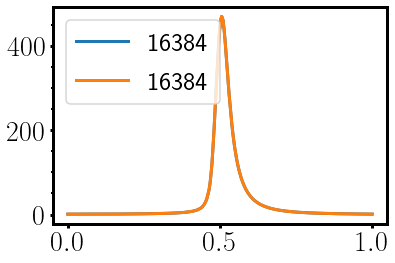

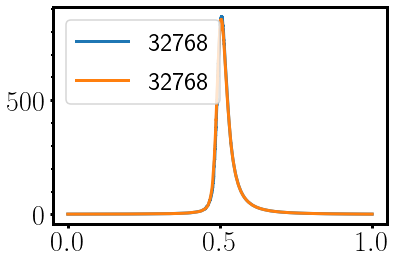

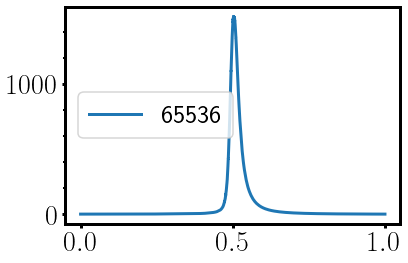

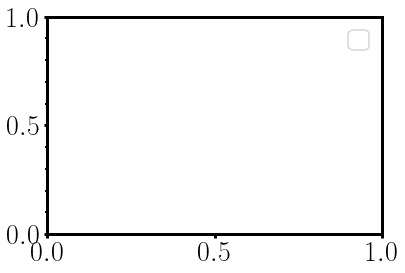

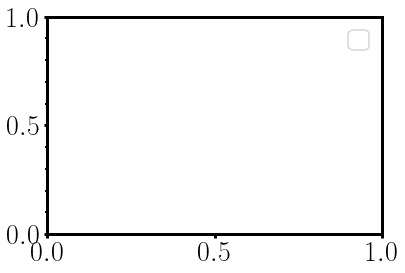

In [42]:
for N in sizes:
    plt.figure()
    if N in dfs_cpp:
        df = dfs_cpp[N]
        plt.plot(df.f, df.meanS, label=N)
    if N in dfs_fast:
        df = dfs_fast[N]
        plt.plot(df.f, df.meanS, label=N)
    plt.legend()

In [110]:
N = 8192
seed = 9999
data_cpp = np.loadtxt(f'../networks/DT/DT_param/DT_param_N{N}/DT_param_N{N}_{seed:05d}/Ran/comp_data.txt')
data_fast = np.loadtxt(f'../networks/DT/DT_param/DT_param_N{N}/DT_param_N{N}_{seed:05d}/Ran/comp_data_fast.txt')

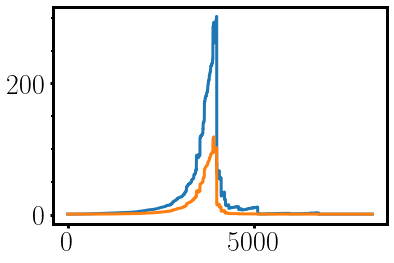

In [111]:
plt.plot(data_cpp[:,2])
plt.plot(data_fast[:,2])

In [100]:
N = 8192
df_cpp  = pd.read_csv(f'../networks/DT/DT_param/DT_param_N{N}/Ran_nSeeds1000_cpp.csv')
df_fast = pd.read_csv(f'../networks/DT/DT_param/DT_param_N{N}/Ran_nSeeds1000_fast.csv')

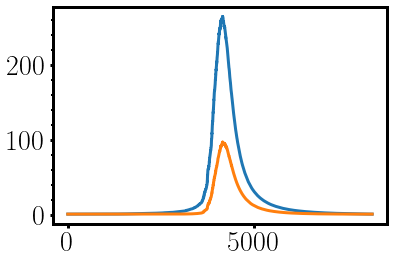

In [101]:
plt.plot(df_cpp.meanS)
plt.plot(df_fast.meanS)

(10,)
0.48000 0.11000 1751367.16584


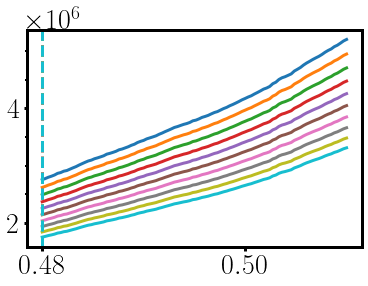

In [3]:
global_min = 1e10
#dfs = dfs_cpp
N_values = list(dfs.keys())
max_N = max(dfs.keys())
f_min, f_max = 0.48, 0.51
x = np.linspace(f_min, f_max, 100)
dx = x[1] - x[0]
chi_values = np.linspace(0.09, 0.11, 10)
print(chi_values.shape)

def get_H_values(dfs):
    H_values = {}
    for N, df in dfs.items():
        X = df.Sgcc.values
        Y = X*N**chi
        xp = df.f.values
        Y = np.interp(x, xp, Y)
        H = Y + 1/Y
        H_values[N] = H
    return H_values

def get_Lambda(H_values):
    Lambda = 0
    for Na, Ha in H_values.items():
        for Nb, Hb in H_values.items():
            if Na == Nb:
                continue
            Lambda += (Ha-Hb)**2
    return Lambda

def get_min(Lambda, f_min, dx):
    min_value = np.min(Lambda)
    min_pos = f_min + dx*np.argmin(Lambda)
    return min_value, min_pos

plot = True
for i, chi in enumerate(chi_values):
    H_values = get_H_values(dfs)
    Lambda = get_Lambda(H_values)
    Lambda_min, fc_chi = get_min(Lambda, f_min, dx)
    if plot:
        plt.plot(x, Lambda)
        plt.axvline(fc_chi, color=f'C{i}', linestyle='--')
        #plt.axhline(Lambda_min, color='k', linestyle='--')
        
    if Lambda_min < global_min:
        global_min = Lambda_min
        fc = fc_chi
print(f'{fc:.5f} {chi:.5f} {global_min:.5f}')

In [235]:
a = 0.1
f'{a:.2f}'

'0.10'

In [192]:
help(np.interp)

Help on function interp in module numpy:

interp(x, xp, fp, left=None, right=None, period=None)
    One-dimensional linear interpolation.
    
    Returns the one-dimensional piecewise linear interpolant to a function
    with given discrete data points (`xp`, `fp`), evaluated at `x`.
    
    Parameters
    ----------
    x : array_like
        The x-coordinates at which to evaluate the interpolated values.
    
    xp : 1-D sequence of floats
        The x-coordinates of the data points, must be increasing if argument
        `period` is not specified. Otherwise, `xp` is internally sorted after
        normalizing the periodic boundaries with ``xp = xp % period``.
    
    fp : 1-D sequence of float or complex
        The y-coordinates of the data points, same length as `xp`.
    
    left : optional float or complex corresponding to fp
        Value to return for `x < xp[0]`, default is `fp[0]`.
    
    right : optional float or complex corresponding to fp
        Value to return f

In [18]:
data1 = {'A': [1, 2, 3], 'B': [2, 4, 6]} 
df1 = pd.DataFrame(data1)
df1

data2 = {'A': [1, 2], 'B': [2, 4]} 
df2 = pd.DataFrame(data2)
df2

,A,B
0,1,2
1,2,4


In [23]:
df1.add(df2, fill_value=1)

,A,B
0,2.0,4.0
1,4.0,8.0
2,4.0,7.0


In [26]:
    input_cols = ['A', 'B']
    df = pd.DataFrame(data=[], columns=input_cols)
    df.add(df1, fill_value=0)

,A,B
0,1,2
1,2,4
2,3,6
